# Calculate site entropy

In [23]:
# Import
import os
import datetime
import math
import re
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import AlignIO
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize, to_hex
from matplotlib.colorbar import ColorbarBase

# Ignore Altair error message about large dataframes
_ = alt.data_transformers.disable_max_rows()

# Display entire Pandas DataFrame column 
pd.set_option('display.max_colwidth', None)

# Get variables
# Uncomment to run interactively
color_scheme = [
    '#345995', #blue
    '#03cea4', #teal
    '#ca1551', #red
    '#eac435', #yellow
               ]

date_start = datetime.date.fromisoformat('2023-05-01')
date_end = datetime.date.fromisoformat('2023-11-01')

date_start = pd.Timestamp(date_start)
date_end = pd.Timestamp(date_end)

entropyfile = '../results/shannon_entropy_gisaid_prots.csv'

# library_sequences_file = '../data/H3_library_constructs_protein.fa'

library_protein_sequences = [
    '../data/H3_library_protein_ectodomain.fa', # Entire HA ectodomain
    '../data/H3_library_protein_HA1.fa' # Just HA1 sequences
]

In [3]:
# Amino acid coordinates of each HA domain
# Inclusive numbering
signal_peptide = [1, 16]
ha1 = [17, 345]
ha2 = [346, 'end']


## Plot GISAID sequence entropy

In [4]:
entropy_df = pd.read_csv(entropyfile)
entropy_df.head(10)

,site,entropy,consensus_res,unique_res_counts
0,1,0.316702,M,"{'-': 877, 'M': 23462, 'X': 303}"
1,2,0.353983,K,"{'-': 872, 'K': 23365, 'N': 29, 'R': 37, 'X': 339}"
2,3,0.588100,T,"{'-': 858, 'A': 922, 'I': 10, 'N': 90, 'P': 2, 'S': 7, 'T': 22438, 'X': 315}"
3,4,0.315856,I,"{'-': 840, 'I': 23518, 'N': 1, 'T': 15, 'V': 48, 'X': 220}"
4,5,0.275993,I,"{'-': 816, 'I': 23646, 'L': 2, 'M': 1, 'T': 8, 'V': 5, 'X': 164}"
5,6,0.257199,A,"{'-': 789, 'A': 23718, 'S': 4, 'T': 9, 'V': 4, 'X': 118}"
6,7,0.246160,L,"{'-': 771, 'F': 8, 'L': 23757, 'S': 1, 'W': 4, 'X': 101}"
7,8,0.239826,S,"{'-': 747, 'E': 1, 'G': 23, 'I': 8, 'N': 1, 'S': 23793, 'X': 69}"
8,9,0.001301,-,"{'-': 24640, 'I': 1, 'X': 1}"
9,10,0.384016,N,"{'-': 745, 'A': 1, 'H': 1, 'K': 8, 'N': 23345, 'Q': 3, 'R': 1, 'S': 199, 'X': 59, 'Y': 280}"


In [5]:
# Define a refactored site value, which is the the site position with all gaps removed.
# There are gaps because the alignment was created with 2 years of sequences,
# But the entropy was calculated across a 6-month subset of those 2 years.

refactored_entropy_df = (entropy_df
                         .set_index(['site'])
                         .query('entropy != 0')
                         .reset_index(drop=False)
                         .rename(columns = {'site': 'old_site'})
                         .reset_index(drop=False)
                         .rename(columns = {'index': 'refactored_site'})
                        )

# Get HA1 DataFrame
ha1_entropy_df = (refactored_entropy_df
                  .query('refactored_site >= 21')
                  .query('refactored_site <= 348')
                  .reset_index(drop=True)
                 )
ha1_entropy_df['site'] = list(range(1,len(ha1_entropy_df)+1))

# Get ectodomain DataFrame
ectodomain_entropy_df = (refactored_entropy_df
                  .query('refactored_site >= 16')
                  .reset_index(drop=True)
                 )
ectodomain_entropy_df['site'] = list(range(1,len(ectodomain_entropy_df)+1))

# ha1_entropy_df.query('site >= 274')
# ha1_entropy_df.head()

In [6]:
def plot_sitewise_entropy(data, title =''):
    
    # Configure chart
    width = 500
    height = 100
    titleFontSize = 16
    labelFontSize = 16
    color = color_scheme[1]

    # Plot the number of mutations at each site using Altair
    chart = alt.Chart(data, width=width, height=height).mark_bar(color = color).encode(
        x=alt.X('site:Q', title='Position',
               axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize),
               scale = alt.Scale(domain=[0,len(data)])),
        y=alt.Y('entropy:Q', title='Shannon entropy',
                axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize)),
        tooltip=['site', 'entropy', 'consensus_res'], 
    ).properties(
        title=title
    ).configure_title(
        fontSize = titleFontSize
    )
    
    return chart


In [7]:
# Generate the plot
chart = plot_sitewise_entropy(ha1_entropy_df, title = 'Entropy in HA1')
chart.display()

alt.Chart(...)

In [8]:
# Generate the plot
chart = plot_sitewise_entropy(ectodomain_entropy_df, title = 'Entropy in HA ectodomain')
chart.display()

alt.Chart(...)

# Plot count of mutations and entropy in H3 library HAs

In [9]:
def count_mutations_by_site(fasta_file):
    # Read the aligned sequences from the FASTA file
    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    
    # Ensure all sequences have the same length (i.e., alignment is proper)
    seq_length = len(sequences[0].seq)
    for seq_record in sequences:
        if len(seq_record.seq) != seq_length:
            raise ValueError("All sequences must be aligned and have the same length.")
    
    # Convert the sequences to a NumPy array for easier column-wise comparison
    alignment = np.array([list(str(record.seq)) for record in sequences])

    # Calculate the consensus sequence (most common residue at each site)
    consensus = []
    for i in range(seq_length):
        column = alignment[:, i]  # Get the column at position i
        most_common_residue = Counter(column).most_common(1)[0][0]  # Find the most common residue
        consensus.append(most_common_residue)
    consensus = np.array(consensus)
    
    # Count mutations relative to the consensus at each site
    mutation_counts = np.sum(alignment != consensus, axis=0)
    
    # Create a pandas DataFrame for easier plotting
    mutation_df = pd.DataFrame({
        'Site': np.arange(1, seq_length + 1),
        'Mutations': mutation_counts,
        'Consensus': consensus
    })

    # Configure chart
    width = 500
    height = 100
    titleFontSize = 16
    labelFontSize = 16
    color = color_scheme[0]

    # Plot the number of mutations at each site using Altair
    chart = alt.Chart(mutation_df, width=width, height=height).mark_bar(color=color).encode(
        x=alt.X('Site:Q', title='Position in Sequence',
               axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize),
               scale = alt.Scale(domain=[0,len(consensus)])),
        y=alt.Y('Mutations:Q', title='Number of Mutations',
                axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize)),
        tooltip=['Site', 'Mutations', 'Consensus']
    ).properties(
        title=f'Mutations by Site in {fasta_file}'
    )
    
    return chart


In [10]:
# Show for both ectodomain and HA1
for file in library_protein_sequences:
    # fasta_file = os.path.join(datadir, file)

    # Generate the plot
    chart = count_mutations_by_site(file)
    chart.display()
        
# chart = count_mutations_by_site("path_to_fasta_file.fasta")
# chart.show()  # If using in a Jupyter notebook, use chart.display() instead

alt.Chart(...)

alt.Chart(...)

In [11]:
# Function to calculate Shannon entropy from a FASTA file
def calculate_entropy(fasta_file: str, use_entries: list = None):
    """
    Reads a FASTA file, optionally filters entries, calculates Shannon entropy for each site, and determines the consensus sequence.

    Args:
        fasta_file (str): Path to the FASTA file containing aligned sequences.
        use_entries (list): Optional list of FASTA entry names (headers) to include in the analysis.

    Returns:
        tuple: (list of entropies, list of consensus symbols)
    """
    # Parse the FASTA file
    all_sequences = list(SeqIO.parse(fasta_file, "fasta"))

    # Filter sequences if a subset of headers is specified
    if use_entries:
        all_sequences = [seq for seq in all_sequences if seq.id in use_entries]
        if not all_sequences:
            raise ValueError("None of the specified FASTA entries were found in the file.")

    # Create an alignment object
    alignment = MultipleSeqAlignment(all_sequences)
    
    entropies = []
    consensus = []
    for i in range(alignment.get_alignment_length()):
        column = [seq[i] for seq in alignment if seq[i] != '-']  # Exclude gaps
        unique, counts = np.unique(column, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities))
        entropies.append(entropy)
        consensus.append(unique[np.argmax(counts)])  # Consensus = most frequent symbol
    
    # return alignment, entropies, consensus

    # Input FASTA file
    # fasta_file = library_protein_sequences[0]  # Replace with the path to your FASTA file
    
    # Calculate entropy and consensus
    # alignment, entropies, consensus = calculate_entropy(fasta_file)
    
    # Create a DataFrame for Altair
    entropy_df = pd.DataFrame({
        "Site": np.arange(1, len(entropies) + 1),  # 1-based indexing
        "Entropy": entropies,
        "Consensus": consensus
    })

    # Configure chart
    width = 500
    height = 100
    titleFontSize = 16
    labelFontSize = 16
    color = color_scheme[0]

    # Plot the number of mutations at each site using Altair
    chart = alt.Chart(entropy_df, width=width, height=height).mark_bar(color=color).encode(
        x=alt.X('Site:Q', title='Position in sequence',
               axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize),
               scale = alt.Scale(domain=[0,len(consensus)])),
        y=alt.Y('Entropy:Q', title='Site entropy',
                axis = alt.Axis(grid=False, titleFontSize=titleFontSize, labelFontSize=labelFontSize)),
        tooltip=['Site', 'Entropy', 'Consensus']
    ).properties(
        title=f'Entropy by Site in {fasta_file}'
    )
    
    return chart, entropy_df

In [12]:
# Show for both ectodomain and HA1
for file in library_protein_sequences:
    # fasta_file = os.path.join(datadir, file)

    # Generate the plot
    chart, dataframe = calculate_entropy(file)
    chart.display()
        
# chart = count_mutations_by_site("path_to_fasta_file.fasta")
# chart.show()  # If using in a Jupyter notebook, use chart.display() instead

alt.Chart(...)

alt.Chart(...)

## Write a `defattr` file for visualizing site entropy on protein structure

In [13]:
# Get full HA ectodomain entropy for library sequences
chart, full_HA_library_entropy = calculate_entropy(library_protein_sequences[0])

# The PDB file is missing the very beginning and ends of the HA protein
full_HA_library_entropy = full_HA_library_entropy[8:498]
# Add renumbering for PDB file
full_HA_library_entropy['site_chain_renumbering'] = [':' + str(s) for s in list(range(9,326))] + [':' + str(s) for s in list(range(1,174))] 

# Define outfile, write defattr file
outfile = 'H3_library_entropy.defattr'
with open(outfile, 'w') as f:
    f.write(
        'attribute: entropy\nmatch mode: 1-to-1\nrecipient: residues\n'
    )
    for letter_pair in [['A', 'B'], ['C', 'D'], ['E', 'F']]:
        for row in full_HA_library_entropy.iterrows():
            site = (row[1]['Site'])
            entropy = round(row[1]['Entropy'], 5) # Round to 5 decimal places
            renumb_site = (row[1]['site_chain_renumbering'])

            if site <= 325:
                letter = letter_pair[0]
            else:
                letter = letter_pair[1]
            
            f.write(
                f'\t/{letter}{renumb_site}\t{entropy}\n'
            )
    

/tmp/ipykernel_73002/2196388852.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_HA_library_entropy['site_chain_renumbering'] = [':' + str(s) for s in list(range(9,326))] + [':' + str(s) for s in list(range(1,174))]


## Draw scale bar using `matplotlib`

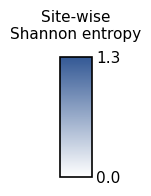

In [31]:
# Get scale bar

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['white', color_scheme[0]])
custom_cmap

# Get custom colormap
colormap = plt.colormaps.get_cmap(custom_cmap)

# Configure
fontSize = 11

# Set custom min and max values for the scale
min_val = -full_HA_library_entropy.Entropy.min()
max_val = round(full_HA_library_entropy.Entropy.max(), 2) # Round to 3 sigfigs

# Normalize the colormap to the min and max values
norm = Normalize(vmin=min_val, vmax=max_val)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(0.8, 1.6))
# fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(left=0.3, right=0.7, top=0.85, bottom=0.1)

# Create the colorbar
cbar = ColorbarBase(ax, cmap=colormap, norm=norm, orientation='vertical')

# Add labels for the colorbar
# cbar.set_label('Growth\nadvantage', fontsize=fontSize, labelpad=10, fontweight ="bold", loc = 'center')  # Add title to the colorbar
cbar.ax.set_yticks([min_val, max_val])       # Set ticks at min and max
cbar.ax.set_yticklabels([f'{min_val}', f'{max_val}'], fontsize=fontSize)  # Label the ticks
ax.tick_params(axis='y',size=0) # Hide ticks 
cbar.outline.set_linewidth(1.2) # Set outline width


# Add the label directly on top of the colorbar
ax.text(0.5, 1.15, 'Site-wise\nShannon entropy', fontsize=fontSize, fontweight ="medium", ha='center', transform=ax.transAxes)

# Save plot
outfile = os.path.join('../results/entropy_heatmap_legend.png')
plt.savefig(outfile, dpi = 600, bbox_inches = 'tight')

plt.show()